# Landmark

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Dryjelly/Face_Ear_Landmark_Detection.git

Cloning into 'Face_Ear_Landmark_Detection'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 194 (delta 105), reused 84 (delta 30), pack-reused 0
Receiving objects: 100% (194/194), 14.51 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
!pip install ultralytics

## Train Ear

In [ ]:
%cd /content/Face_Ear_Landmark_Detection

/content/Face_Ear_Landmark_Detection


In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as im

import numpy as np
import glob
import cv2
import os

from model_config.model import *
from scipy import io


data_dir_train = '/content/drive/MyDrive/Prohibited behavior/Data/CollectionA/train/'
data_dir_test = '/content/drive/MyDrive/Prohibited behavior/Data/CollectionA/test/'

# file_list = os.listdir(data_dir)
file_list_train = glob.glob(data_dir_train+'*.png')
file_list_test = glob.glob(data_dir_test+'*.png')

name_list_train = list(set(map(lambda x : x[:-4], file_list_train)))
name_list_test = list(set(map(lambda x : x[:-4], file_list_test)))


INPUT_SIZE = 368
MAP_SIZE = 100
MAP_SIGMA = 2.5

LANDMARK_NUM = list(range(55))#[4,9,16,36] # 원하는 point 를 입력
LANDMARK_SIZE = len(LANDMARK_NUM) # ear : 55 / face : 68
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCH = 100

split_rate = 0.9

def _stage_loss(y_true, y_pred):
    stage = 6
    #y_ture = tf.image.resize(y_true, size=[feat_size, feat_size])
    #threshold = 0.0001
    mask = y_true != 0 #> threshold
    resized_mask   = tf.tile(mask, [1,1,1,stage])
    resized_y_true = tf.tile(y_true, [1,1,1,stage])
    resized_y_pred = y_pred
    #resized_y_pred = tf.image.resize(y_pred, size=[INPUT_SIZE, INPUT_SIZE])
    resized_y_pred = tf.image.resize(y_pred, size=[MAP_SIZE, MAP_SIZE])

    loss = tf.math.reduce_mean(tf.math.square(resized_y_true - resized_y_pred) * tf.cast(resized_mask, tf.float32), axis=-1)
    #loss = tf.math.reduce_mean(tf.math.square(resized_y_true - resized_y_pred), axis=-1)

    #loss = tf.keras.losses.mean_squared_error(resized_y_true, resized_y_pred)
    return loss

# model = tf.keras.Model(inputs=[x], outputs=[output])
model = model_openpose_a2a_v2(LANDMARK_SIZE=LANDMARK_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=_stage_loss)

# model = keras.models.load_model('saved_model_openpose_ears_ver4', compile=False)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=_stage_loss)
model.summary()

input_size_h = INPUT_SIZE/2
feat_size = model.get_layer('feature_map').output_shape[1]

#--------------------------------------

train_len = len(name_list_train)
test_len = len(name_list_test)

train_dataset = tf.data.Dataset.from_tensor_slices(name_list_train)
test_dataset = tf.data.Dataset.from_tensor_slices(name_list_test)

def process_path(name):
    #image_path = data_dir+name+'.jpg'
    image_path = name+'.png'
    image = tf.io.read_file(image_path)
    #image = tf.image.decode_jpeg(image)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cond(tf.shape(image)[-1] != 3,
                    lambda: tf.image.grayscale_to_rgb(image),
                    lambda: tf.identity(image))
    image_shape = tf.shape(image)

    #label = tf.numpy_function(_read_txt, [landmark_dir+name+'_pts.mat', image_shape], tf.float32)
    # label = tf.numpy_function(_read_txt, [landmark_dir+name+'.txt', image_shape], tf.float32)
    label = tf.numpy_function(_read_pts, [name+'.pts', image_shape], tf.float32)

    image, label = tf.numpy_function(_shrink_image_one, [image, label], [tf.float32, tf.float32])
    image, label = tf.numpy_function(_crop_image_one, [image, label], [tf.float32, tf.float32])
    #image, label = tf.numpy_function(_shift_image_one, [image, label], [tf.float32, tf.float32])
    image, label = tf.py_function(_flip_image_one, [image, label], [tf.float32, tf.float32])

    label = tf.numpy_function(_make_confidence_map, [label, MAP_SIGMA], tf.float32)

    image.set_shape([None, None, None])
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])

    #image.set_shape([INPUT_SIZE, INPUT_SIZE, 3])
    label.set_shape([MAP_SIZE, MAP_SIZE, LANDMARK_SIZE])
    #image = tf.reshape(image, shape=[input_size, input_size, 3])
    #label = tf.reshape(label, shape=[-1])

    return image, label

def _read_mat(file_path, input_shape):
    matfile = io.loadmat(file_path)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((matfile['pts_2d']-norm)/norm).astype(np.float32)
    return label

def _read_txt(file_path, input_shape):
    with open(file_path, 'r') as f:
        lines_list = f.readlines()
        temp = list(map(lambda l : list(map(float, l.split(' '))), lines_list[3:-1]))
        temp = np.array(temp)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((temp-norm)/norm).astype(np.float32)
    return label[LANDMARK_NUM]

def _read_pts(file_path, input_shape):
    ptsfile = np.loadtxt(str(file_path, 'utf-8'), comments=("version:", "n_points:", "{", "}"))
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((ptsfile-norm)/norm).astype(np.float32)
    return label[LANDMARK_NUM]

def _make_confidence_map(label, sigma = 2.5):

    norm = [MAP_SIZE/2, MAP_SIZE/2]
    new_label = label*norm+norm

    grid_x = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1))
    grid_y = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1)).transpose()
    grid_x = np.tile(np.expand_dims(grid_x, axis=-1),LANDMARK_SIZE)
    grid_y = np.tile(np.expand_dims(grid_y, axis=-1),LANDMARK_SIZE)

    grid_distance = (grid_x - new_label[:,0]) ** 2 + (grid_y - new_label[:,1]) ** 2
    confidence_map = np.exp(-1 * grid_distance / sigma ** 2) # why 0.5?

    return confidence_map.astype(np.float32)

def _crop_image_one(img, label): # with label norm
    pad = 1

    img_h, img_w, img_c = img.shape

    idx = np.array([img_w/2, img_h/2])

    label = label*idx+idx

    label_x_info = np.array([min(label[:,0]), max(label[:,0])])
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])

    ear_w = label_x_info[1]-label_x_info[0]
    ear_h = label_y_info[1]-label_y_info[0]

#     s_x = max(int(label_x_info[0]-ear_w*1-pad), 0)
#     e_x = min(int(label_x_info[0]+ear_w*8), img_w)
#     s_y = max(int(label_y_info[0]-ear_h*2-pad), 0)
#     e_y = min(int(label_y_info[0]+ear_h*3), img_h)

    s_x = max(int(label_x_info[0]-ear_w*10), 0)
    e_x = min(int(label_x_info[0]+ear_w*10), img_w)
    s_y = max(int(label_y_info[0]-ear_h*10), 0)
    e_y = min(int(label_y_info[0]+ear_h*10), img_h)

#     s_x = max(int(label_x_info[0]-ear_w*1-pad), 0)
#     e_x = min(int(label_x_info[1]+ear_w*1), img_w)
#     s_y = max(int(label_y_info[0]-ear_h*1-pad), 0)
#     e_y = min(int(label_y_info[1]+ear_h*1), img_h)

#     s_x = max(int(label_x_info[0]-pad), 0)
#     e_x = min(int(label_x_info[1]+pad), img_w)
#     s_y = max(int(label_y_info[0]-pad), 0)
#     e_y = min(int(label_y_info[1]+pad), img_h)

    c_img = img[s_y:e_y, s_x:e_x, :]
    c_label = label - np.array([s_x, s_y])

    new_img_h, new_img_w, _ = c_img.shape

    norm = [new_img_w/2, new_img_h/2]
    c_label = ((c_label-norm)/norm).astype(np.float32)
    return c_img, c_label

def _shrink_image_one(img, label):
    img_h, img_w, img_c = img.shape
    idx = np.array([img_w/2, img_h/2])
    label = label*idx+idx

    max_ratio = 4
    sh_ratio = np.random.randint(1,max_ratio)

    min_x = int(np.min(label[:,0]))
    max_x = int(np.max(label[:,0]))

    image_left = img[:,0:min_x,:]
    image_right = img[:,max_x:-1,:]
    image_mid = img[:,min_x:max_x:sh_ratio,:]

    sh_img = np.concatenate((image_left, image_mid, image_right), axis = 1)
    sh_label = (label-np.array([min_x,0]))/np.array([sh_ratio,1])+np.array([min_x,0])

    new_img_h, new_img_w, _ = sh_img.shape
    norm = [new_img_w/2, new_img_h/2]
    sh_label = ((sh_label-norm)/norm).astype(np.float32)

    return sh_img, sh_label

def _flip_image_one(img, label):
    c = np.random.randint(2)
    f_img, f_label = tf.cond(c==1,
                             lambda: (tf.image.flip_left_right(img), label * np.array([-1, 1])),
                             lambda: (img, label))
    #f_img = tf.image.resize(f_img, [input_size, input_size])
    return f_img, f_label

def _shift_image_one(img, label, padding = b'zero'):
    img_h, img_w, img_c = img.shape
    label_p, _ = label.shape

    if padding == b'ori': s_img = img[:]
    elif padding == b'zero': s_img = np.zeros_like(img, dtype=np.float32)
    s_label = np.expand_dims(label, axis=0)

    label_x_info = np.array([min(label[:,0]), max(label[:,0])])* img_w/2 + img_w/2
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])* img_h/2 + img_h/2

    label_x_info = label_x_info.astype(np.int)
    label_y_info = label_y_info.astype(np.int)

    shift_x = np.random.randint(-label_x_info[0], img_w - label_x_info[1])
    shift_y = np.random.randint(-label_y_info[0], img_h - label_y_info[1])

    shift_x = min(shift_x, img_w//6)
    shift_y = min(shift_y, img_h//6)

    if shift_x < 0:
        get_x = (-shift_x, img_w)
        put_x = (0, img_w + shift_x)
    else:
        get_x = (0, img_w - shift_x)
        put_x = (shift_x, img_w)
    if shift_y < 0:
        get_y = (-shift_y, img_h)
        put_y = (0, img_h + shift_y)
    else:
        get_y = (0, img_h - shift_y)
        put_y = (shift_y, img_h)

    if padding == b'edge': s_img = np.pad(img[get_y[0]:get_y[1], get_x[0]:get_x[1], :], ((img_h-get_y[1],get_y[0]),(img_w-get_x[1],get_x[0]),(0,0)), mode='edge')
    else: s_img[put_y[0]:put_y[1], put_x[0]:put_x[1], :] = img[get_y[0]:get_y[1], get_x[0]:get_x[1], :]
    s_label = np.append(np.expand_dims(label[:,0] + (shift_x)/(img_w/2), axis = -1),
                          np.expand_dims(label[:,1] + (shift_y)/(img_h/2), axis = -1), axis = 1)

    return s_img, s_label

AUTOTUNE = tf.data.experimental.AUTOTUNE


train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


train_step = train_len//BATCH_SIZE
test_step = test_len//BATCH_SIZE

history = model.fit(train_dataset,
                    epochs=EPOCH,
                    steps_per_epoch=train_step,
                    validation_steps=test_step,
                    validation_data=test_dataset,
                    verbose=2)


model.save(f'/content/drive/MyDrive/Prohibited behavior/saved_model/{EPOCH}/saved_model_openpose_ear_v1.h5')

## Demo


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from scipy.ndimage import gaussian_filter

import cv2
from google.colab.patches import cv2_imshow

from tqdm.notebook import tqdm
from imutils import paths

# from ultralytics import YOLO

from IPython.display import clear_output

model = tf.keras.models.load_model('/content/drive/MyDrive/Prohibited behavior/saved_model/100/saved_model_openpose_ear_v1.h5', compile=False)

pred = tf.keras.backend.function([model.input], [model.get_layer('s6').output])

# earphone_detector = YOLO('/content/drive/MyDrive/Prohibited behavior/saved_model/DNG_YOLOv8m_Earphone/best_train23_onlyEarphone.pt')

In [4]:
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

def apply_blur(img, landmark):
    blur = _gaussian_kernel(5, 2.5, landmark, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return img[0]

In [5]:
#---setting------------------------------#

# model input size
input_size = 368#200

# ear model
landmark_size = 55
ear_part_num = [20, 15, 15, 5]
ear_threshold = 0.5

# face model
landmark_size_face = 68
face_threshold = 0.0

# resize setting for coordinate correction
r_size = 368#200

# capture size (Default = 620x480)
IM_W = 1280
IM_H = 720

# output size (Default = 620x480)
o_size_w = 720
o_size_h = 720

#text loc
text_loc = (50,50)
# fontScale
fontScale = 1
# font text
font = cv2.FONT_HERSHEY_SIMPLEX
# text color in BGR
text_color = (0, 255, 0)
# Line thickness of 2 px
thickness = 2

color_list = [(0,255,0), (255,51,0), (255,204,0), (0,204,255)]
#----------------------------------------#

In [6]:
def extract_ear(frame,pts,idx):
  mask = np.zeros(frame.shape[:2], dtype='uint8')

  cv2.polylines(mask, [np.asarray(pts[idx])], True , (255,255,255), 2)
  cv2.fillConvexPoly(mask, np.asarray(pts[idx]), 255)

  masked_image = cv2.bitwise_and(frame,frame, mask=mask)

  return mask, masked_image

In [7]:
def extract_inside_ear(frame,pts,idx):
  mask = np.zeros(frame.shape[:2], dtype='uint8')

  cv2.polylines(mask, [np.asarray(pts)], True , (255,255,255), 2)
  cv2.fillConvexPoly(mask, np.asarray(pts), 255)

  masked_image = cv2.bitwise_and(frame,frame, mask=mask)

  return mask, masked_image

In [8]:
def extract_outside_ear(frame,mask1, mask2):
  XOR_mask = cv2.bitwise_xor(mask1,mask2)
  masked_image = cv2.bitwise_and(frame,frame, mask=XOR_mask)

  return masked_image

In [9]:
def histogram(img):
    b_img = img[:,:,0]
    g_img = img[:,:,1]
    r_img = img[:,:,2]
    nzb_indices = np.nonzero(b_img)
    flat_img = img.flatten()
    nz_indices = np.nonzero(flat_img)
    avg_b = np.mean(b_img[nzb_indices])
    avg_g = np.mean(g_img[nzb_indices])
    avg_r = np.mean(r_img[nzb_indices])
    avg_color = np.mean(flat_img[nz_indices])
    H,counts = np.unique(flat_img[nz_indices], return_counts=True)

    return H,avg_color,avg_b,avg_g,avg_r,counts

In [25]:
def check_abnormal_ear(frame,prev_xy,inner_xy):
  #extract ear
  mask1, masked_ear = extract_ear(frame,prev_xy,0) #ear
  mask2, masked_inside1 = extract_ear(frame,prev_xy,2) #inner region
  mask21, masked_inside2 = extract_inside_ear(frame,inner_xy,2) #inner region
  masked_outside = extract_outside_ear(frame,mask1, mask21) #outer region
  # check abnormal ear
  hist_1,avg_color1,avg_b1,avg_g1,avg_r1,count_1 = histogram(masked_outside) #outer region
  hist_2,avg_color2,avg_b2,avg_g2,avg_r2,count_2 = histogram(masked_inside2) #inner region

  print(avg_color2, avg_b2,avg_g2,avg_r2)
  cv2_imshow(masked_inside2)
  print(avg_color1, avg_b1,avg_g1,avg_r1)
  cv2_imshow(masked_outside)

  flag = 0
  if abs(avg_b2 - avg_b1) >= 20 or abs(avg_g2 - avg_g1) >= 20 or abs(avg_r2 - avg_r1) >= 20:
    check_output = 'Abnormal Ear'
    return [abs(avg_b2 - avg_b1),abs(avg_g2 - avg_g1), abs(avg_r2 - avg_r1)], check_output

  if abs(avg_b2 - avg_b1) >= 15:
    flag += 1
  if abs(avg_g2 - avg_g1) >= 15:
    flag += 1
  if abs(avg_r2 - avg_r1) >= 15:
    flag += 1
  # if abs(avg_color1-avg_color2) >= 12:
  #   check_output = 'Abnormal Ear'
  # else:
  #   check_output = 'Normal Ear'

  if flag > 1:
    check_output = 'Abnormal Ear'
  else:
    check_output = 'Normal Ear'
  return [abs(avg_b2 - avg_b1),abs(avg_g2 - avg_g1), abs(avg_r2 - avg_r1)], check_output

### **Run data test**

In [11]:
# data_test = '/content/drive/MyDrive/Prohibited behavior/Synthesis_data/Test dataset'
# data_test = '/content/drive/MyDrive/Prohibited behavior/Synthesis_data/Test'
data_test = '/content/drive/MyDrive/Prohibited behavior/real data/test set'
# data_test = '/content/drive/MyDrive/Prohibited behavior/Test set'
test_paths = list(paths.list_images(data_test))

In [ ]:
subtracted_value_list = []
failed_case_norm_list = []
failed_case_abnorm_list = []
check1 = 0
check2 = 0
TP, TN, FP, FN = 0, 0, 0, 0
checka = 0
check = 0
for img_path in tqdm(test_paths):
  img_type = img_path.split('/')[-1].split('_')[0]
  print(img_path.split('/')[-1])
  # if check == 10:
  #   break
  # if img_type != 'abnormal':
  #   continue
  if img_type == 'abnormal':
    check1 += 1
  if img_type == 'normal':
    check2 += 1

  img = cv2.imread(img_path)

  IM_H, IM_W, IM_C = img.shape
  frame = img.copy()

  start = time.time()  # 시작 시간 저장

  # 정사각형 형태로 이미지 자르기 위함
  cut_w_r = (IM_W - IM_H) // 2
  cut_w_l = IM_W - cut_w_r
  # ret, frame = capture.read()

  frame = cv2.resize(frame, (o_size_w, o_size_h), interpolation = cv2.INTER_AREA)
  # frame = frame[:,cut_w_r:cut_w_l,:]
  # frame = cv2.flip(frame, 1)

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, dsize=(input_size, input_size), interpolation=cv2.INTER_AREA)

  # ear-detect---------------------------------------------------------------
  result = pred([np.expand_dims(image, axis=0)/255.])[0]
  result[result < ear_threshold] = 0 # threshold setting
  result = tf.image.resize(result, [r_size, r_size])
  result = apply_blur(result, landmark_size).numpy()
  result = np.argmax(result.reshape(-1,landmark_size), axis=0)

  prev_xy = [[],[],[],[]]
  frame = cv2.resize(frame, dsize=(o_size_w, o_size_h), interpolation=cv2.INTER_AREA)
  copy_frame = frame.copy()

  minX, minY = float("INF"), float("INF")
  maxX, maxY = float("-INF"), float("-INF")
  inner_xy = []
  for i, idx in enumerate(result):
      x, y = idx%r_size/r_size*o_size_w, idx//r_size/r_size*o_size_h
      point = (int(x),int(y))
      if x < 1 or y < 1 : continue
      minX, maxX = min(minX,x), max(maxX,x)
      minY, maxY = min(minY,y), max(maxY,y)

      if (i > 39 and i < 50) or (i == 0) or (i > 16 and i < 20):
        inner_xy.append([int(x),int(y)])

      if i > 49:
        prev_xy[3].append([int(x),int(y)]);
        cv2.circle(frame, point, 2, color_list[3], -1)
        continue
      if i > 34:
        prev_xy[2].append([int(x),int(y)]);
        cv2.circle(frame, point, 2, color_list[2], -1)
        continue
      if i > 19:
        prev_xy[1].append([int(x),int(y)]);
        cv2.circle(frame, point, 2, color_list[1], -1)
        continue
      prev_xy[0].append([int(x),int(y)])
      cv2.circle(frame, point, 2, color_list[0], -1)

  # -------------------------------------------------------------------------
  check_output = ""
  check_len_points = len(prev_xy[0])+len(prev_xy[1])+len(prev_xy[2])+len(prev_xy[3])
  if check_len_points == 55:
    temp = inner_xy.pop(0)
    inner_xy.append(temp)
    inner_xy[0], inner_xy[1], inner_xy[2] = inner_xy[2], inner_xy[1], inner_xy[0]
    # if len(prev_xy[2])==ear_part_num[2]:cv2.polylines(frame, [np.asarray(prev_xy[2])], False , color_list[2], 2)
    for i, xy in enumerate(prev_xy):
        if len(xy)==ear_part_num[i]:cv2.polylines(frame, [np.asarray(xy)], False , color_list[i], 2)

    subtracted_value, text_output = check_abnormal_ear(copy_frame,prev_xy,inner_xy)
    subtracted_value_list.append(subtracted_value)
    print(subtracted_value)
    print(text_output)
    # if (text_output == 'Normal Ear'):
    #   check += 1
    # elif (text_output == 'Abnormal Ear'):
    #   checka += 1

    if (img_type == 'abnormal' and text_output == 'Abnormal Ear'):
      TP += 1
    elif (img_type == 'abnormal' and text_output == 'Normal Ear'):
      FP += 1
    elif (img_type == 'normal' and text_output == 'Normal Ear'):
      TN += 1
    elif (img_type == 'normal' and text_output == 'Abnormal Ear'):
      FN += 1
    # cv2_imshow(frame)
  else:
    if (img_type == 'abnormal'):
      failed_case_abnorm_list.append(img_path.split('/')[-1])
    elif (img_type == 'normal'):
      failed_case_norm_list.append(img_path.split('/')[-1])
    # cv2_imshow(frame)
  # guide line
  # cv2.ellipse(frame, (o_size_w//2,o_size_h//2), (o_size_w//5,o_size_h//3), 0, 0, 360, (0, 255, 0), 1)


In [ ]:
print(check1)
print(check2)

70
70


In [ ]:
failed_case_abnorm_list

[]

In [ ]:
def cal_metrics(TP,TN,FP,FN):
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2 * precision * recall / (precision + recall)

  return accuracy, precision, recall, f1_score

In [ ]:
print(TP,TN,FP,FN)

83 36 17 61


In [ ]:
accuracy, precision, recall, f1_score = cal_metrics(TP,TN,FP,FN)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Accuracy: 0.6040609137055838
Precision: 0.83
Recall: 0.5763888888888888
F1 Score: 0.680327868852459


### **Video**

In [ ]:
capture = cv2.VideoCapture('/content/drive/MyDrive/Prohibited behavior/khoi.mp4')
# capture.set(cv2.CAP_PROP_FRAME_WIDTH, IM_W)
# capture.set(cv2.CAP_PROP_FRAME_HEIGHT, IM_H)
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))
fps = int(capture.get(5))
total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
process = tqdm(total=total_frames)
size = (o_size_w, o_size_h)

start = time.time()  # 시작 시간 저장

# 정사각형 형태로 이미지 자르기 위함
cut_w_r = (frame_width - frame_height) // 2
cut_w_l = frame_width - cut_w_r
output = cv2.VideoWriter("/content/output.mp4",
                              cv2.VideoWriter_fourcc(*'mp4v'),
                              fps, size)

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
      break
    process.update(1)
    # frame = cv2.resize(frame, (o_size_w, o_size_h), interpolation = cv2.INTER_AREA)
    # frame = frame[:,cut_w_r:cut_w_l,:]
    # frame = cv2.flip(frame, 1)

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(input_size, input_size), interpolation=cv2.INTER_AREA)

    # ear-detect---------------------------------------------------------------
    result = pred([np.expand_dims(image, axis=0)/255.])[0]
    result[result < ear_threshold] = 0 # threshold setting
    result = tf.image.resize(result, [r_size, r_size])
    result = apply_blur(result, landmark_size).numpy()
    result = np.argmax(result.reshape(-1,landmark_size), axis=0)

    frame = cv2.resize(frame, dsize=(o_size_w, o_size_h), interpolation=cv2.INTER_AREA)
    copy_frame = frame.copy()

    prev_xy = [[],[],[],[]]
    inner_xy = []
    for i, idx in enumerate(result):
        x, y = idx%r_size/r_size*o_size_w, idx//r_size/r_size*o_size_h
        point = (int(x),int(y))
        if x < 1 or y < 1 : continue
        minX, maxX = min(minX,x), max(maxX,x)
        minY, maxY = min(minY,y), max(maxY,y)

        if (i > 39 and i < 50) or (i == 0) or (i > 16 and i < 20):
          inner_xy.append([int(x),int(y)])

        if i > 49:
          prev_xy[3].append([int(x),int(y)]);
          cv2.circle(frame, point, 2, color_list[3], -1)
          continue
        if i > 34:
          prev_xy[2].append([int(x),int(y)]);
          cv2.circle(frame, point, 2, color_list[2], -1)
          continue
        if i > 19:
          prev_xy[1].append([int(x),int(y)]);
          cv2.circle(frame, point, 2, color_list[1], -1)
          continue
        prev_xy[0].append([int(x),int(y)])
        cv2.circle(frame, point, 2, color_list[0], -1)

    # -------------------------------------------------------------------------
    check_output = ""
    check_len_points = len(prev_xy[0])+len(prev_xy[1])+len(prev_xy[2])+len(prev_xy[3])
    if check_len_points == 55:
      temp = inner_xy.pop(0)
      inner_xy.append(temp)
      inner_xy[0], inner_xy[1], inner_xy[2] = inner_xy[2], inner_xy[1], inner_xy[0]
      # if len(prev_xy[2])==ear_part_num[2]:cv2.polylines(frame, [np.asarray(prev_xy[2])], False , color_list[2], 2)
      for i, xy in enumerate(prev_xy):
          if len(xy)==ear_part_num[i]:cv2.polylines(frame, [np.asarray(xy)], False , color_list[i], 2)

      subtracted_value, text_output = check_abnormal_ear(copy_frame,prev_xy,inner_xy)
      frame = cv2.putText(frame, text_output, (10,30), font,
            fontScale, text_color, thickness, cv2.LINE_AA)
      frame = cv2.putText(frame, "Subtracted value:" + str(subtracted_value), (10,50), font,
                    fontScale*0.5, text_color, thickness, cv2.LINE_AA)

    output.write(frame)
    # guide line
    cv2.ellipse(frame, (o_size_w//2,o_size_h//2), (o_size_w//5,o_size_h//3), 0, 0, 360, (0, 255, 0), 1)


capture.release()
output.release()
cv2.destroyAllWindows()

### **Image**

184.24837042031916 177.6090479405807 175.63808237677245 200.15259959486832


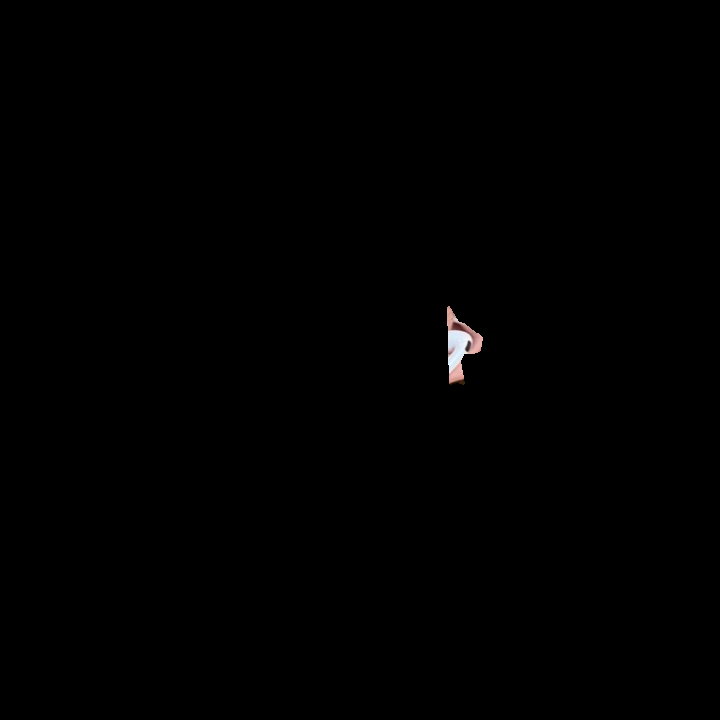

152.92379058979458 131.74234592445328 137.2572564612326 189.7717693836978


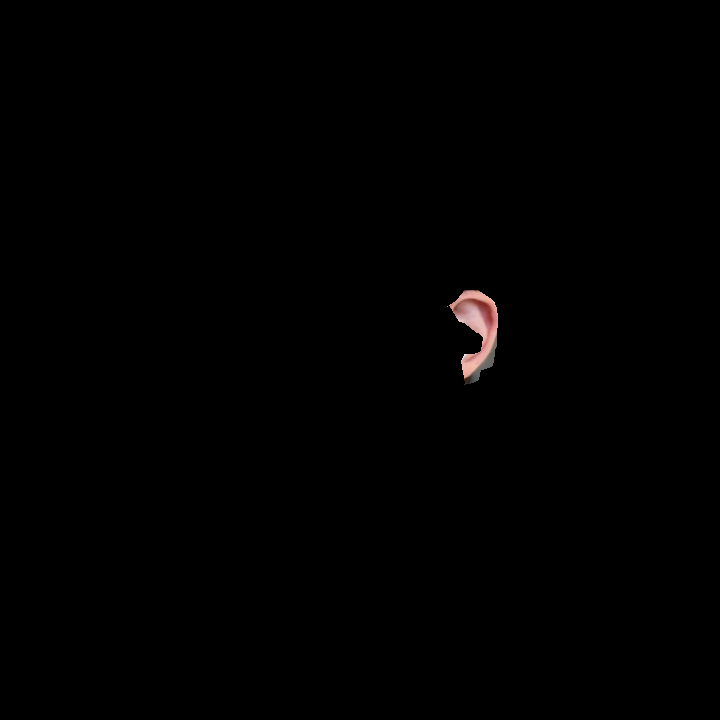

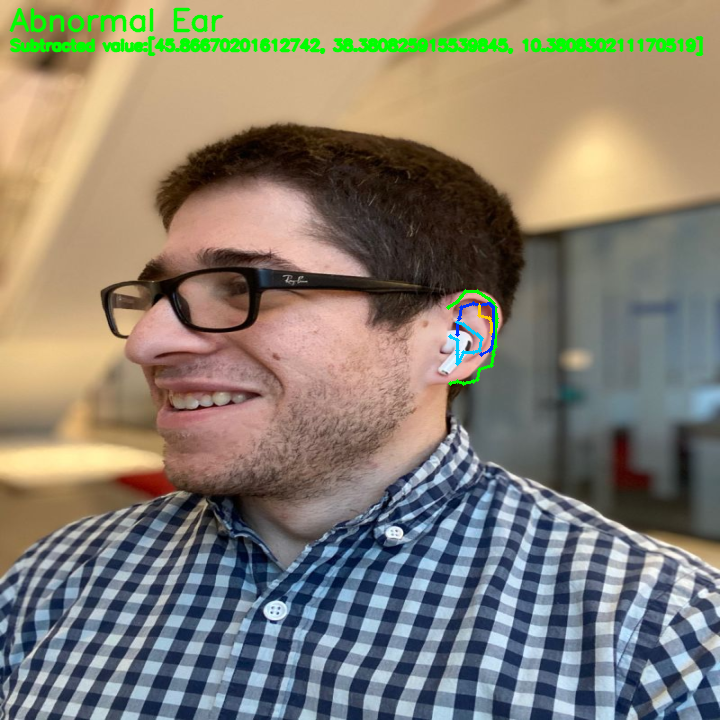

In [27]:
# img = cv2.imread('/content/drive/MyDrive/Prohibited behavior/Data/CollectionA/train/train_0114.png')
img = cv2.imread('/content/drive/MyDrive/Prohibited behavior/real data/test set/abnormal_ear_0033.jpg')
# img = cv2.imread('/content/z4936803726521_1407aa99c02e468674d813fd68d740c6.jpg')

IM_H, IM_W, IM_C = img.shape
frame = img.copy()

start = time.time()  # 시작 시간 저장

# 정사각형 형태로 이미지 자르기 위함
cut_w_r = (IM_W - IM_H) // 2
cut_w_l = IM_W - cut_w_r
# ret, frame = capture.read()

# frame = cv2.resize(frame, (o_size_w, o_size_h), interpolation = cv2.INTER_AREA)
# frame = frame[:,cut_w_r:cut_w_l,:]
# frame = cv2.flip(frame, 1)

image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, dsize=(input_size, input_size), interpolation=cv2.INTER_AREA)
# print('image shape:',image.shape)

# ear-detect---------------------------------------------------------------
result = pred([np.expand_dims(image, axis=0)/255.])[0]
# print(result)
# print(result.shape)
result[result < ear_threshold] = 0 # threshold setting
result = tf.image.resize(result, [r_size, r_size])
result = apply_blur(result, landmark_size).numpy()
result = np.argmax(result.reshape(-1,landmark_size), axis=0)
# print(result)
prev_xy = [[],[],[],[]]
frame = cv2.resize(frame, dsize=(o_size_w, o_size_h), interpolation=cv2.INTER_AREA)
copy_frame = frame.copy()
inner_xy = []
for i, idx in enumerate(result):
    x, y = idx%r_size/r_size*o_size_w, idx//r_size/r_size*o_size_h
    point = (int(x),int(y))
    if x < 1 or y < 1 : continue
    minX, maxX = min(minX,x), max(maxX,x)
    minY, maxY = min(minY,y), max(maxY,y)

    if (i > 39 and i < 50) or (i == 0) or (i > 16 and i < 20):
      inner_xy.append([int(x),int(y)])

    if i > 49:
      prev_xy[3].append([int(x),int(y)]);
      cv2.circle(frame, point, 2, color_list[3], -1)
      continue
    if i > 34:
      prev_xy[2].append([int(x),int(y)]);
      cv2.circle(frame, point, 2, color_list[2], -1)
      continue
    if i > 19:
      prev_xy[1].append([int(x),int(y)]);
      cv2.circle(frame, point, 2, color_list[1], -1)
      continue
    prev_xy[0].append([int(x),int(y)])
    cv2.circle(frame, point, 2, color_list[0], -1)

# -------------------------------------------------------------------------
check_output = ""
check_len_points = len(prev_xy[0])+len(prev_xy[1])+len(prev_xy[2])+len(prev_xy[3])
if check_len_points == 55:
  temp = inner_xy.pop(0)
  inner_xy.append(temp)
  inner_xy[0], inner_xy[1], inner_xy[2] = inner_xy[2], inner_xy[1], inner_xy[0]
  # if len(prev_xy[2])==ear_part_num[2]:cv2.polylines(frame, [np.asarray(prev_xy[2])], False , color_list[2], 2)
  for i, xy in enumerate(prev_xy):
      if len(xy)==ear_part_num[i]:cv2.polylines(frame, [np.asarray(xy)], False , color_list[i], 2)

  subtracted_value, text_output = check_abnormal_ear(copy_frame,prev_xy,inner_xy)
  frame = cv2.putText(frame, text_output, (10,30), font,
            fontScale, text_color, thickness, cv2.LINE_AA)
  frame = cv2.putText(frame, "Subtracted value:" + str(subtracted_value), (10,50), font,
                fontScale*0.5, text_color, thickness, cv2.LINE_AA)


# guide line
# cv2.ellipse(frame, (o_size_w//2,o_size_h//2), (o_size_w//5,o_size_h//3), 0, 0, 360, (0, 255, 0), 1)
cv2_imshow(frame)

In [28]:
subtracted_value

[45.86670201612742, 38.380825915539845, 10.380830211170519]